# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-20 10:29:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'data.txt.zip'

data.txt.zip            [              <=>   ] 201.24M  74.9MB/s    in 2.7s    

2024-10-20 10:30:00 (74.9 MB/s) - 'data.txt.zip' saved [211011981]



In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [7]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [8]:
set_random_seed(42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=1)
model.fit(X_train, y_train)
rmse_train = mean_squared_error(y_train, model.predict(X_train), squared=False)
rmse_test = mean_squared_error(y_test, model.predict(X_test), squared=False)
print('Ridge RMSE Train:', rmse_train)
print('Ridge RMSE Test:', rmse_test)

Ridge RMSE Train: 9.552822967970322
Ridge RMSE Test: 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
y_train_pred = np.full_like(y_train, np.mean(y_train))
y_test_pred = np.full_like(y_test, np.mean(y_train))

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print('CONST RMSE Train:', rmse_train)
print('CONST RMSE Test:', rmse_test)

CONST RMSE Train: 10.946566221164124
CONST RMSE Test: 10.863228020678134


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].unsqueeze(0)

In [12]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(90, 1)

    def forward(self, X):
        return self.linear(X)

In [13]:
set_random_seed(42)
model = LinearRegression()
model.to(device)

LinearRegression(
  (linear): Linear(in_features=90, out_features=1, bias=True)
)

In [14]:
train_set = MyDataset(X_train, y_train)
test_set = MyDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=False
)

In [15]:
res_train = []
res_test = []

def step(param, grad, learning_rate):
    return param - learning_rate * grad

def MSE(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

for epoch in tqdm(range(10)):
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        loss = MSE(y_pred, y_batch)
        
        model.zero_grad()
        loss.backward()
        
        #взято отсюда https://discuss.pytorch.org/t/updatation-of-parameters-without-using-optimizer-step/34244/2
        with torch.no_grad():
            for p in model.parameters():
                new_val = step(p, p.grad, learning_rate=0.01)
                p.copy_(new_val)
    
    train_loss = []
    test_loss = []
    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = MSE(y_pred, y_batch)
            train_loss.append(loss)
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = MSE(y_pred, y_batch)
            test_loss.append(loss)
    res_train.append(torch.sqrt(torch.mean(torch.tensor(train_loss))))
    res_test.append(torch.sqrt(torch.mean(torch.tensor(test_loss))))

  0%|          | 0/10 [00:00<?, ?it/s]

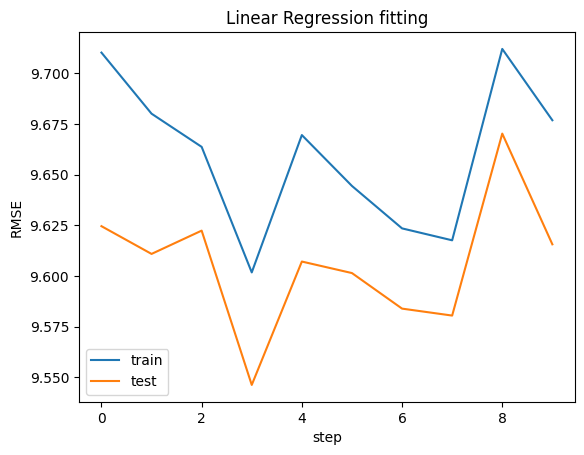

In [16]:
fig, ax = plt.subplots()

ax.plot(res_train, label='train')
ax.plot(res_test, label='test')
ax.legend()
ax.legend()
ax.set_title('Linear Regression fitting')
ax.set_xlabel('step')
ax.set_ylabel('RMSE')
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [17]:
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
y_test = scaler.transform(y_test.reshape(-1, 1)).squeeze()

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.bn1 = nn.BatchNorm1d(90)
        self.fc1 = nn.Linear(90, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)
        
    def forward(self, X):
        X = F.relu(self.fc1(self.bn1(X)))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return X

In [19]:
set_random_seed(42)

train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True
)

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=True
)

model = Net()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.1)
criterion = nn.MSELoss()

In [20]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epochs):
    res_train = []
    res_test = []
    for epoch in tqdm(range(1, n_epochs + 1)):
        print(f'Epoch {epoch}/{n_epochs}')
        train_loss = []
        test_loss = []
        
        model.train()
        for X_batch, y_batch in tqdm(train_loader):
            #обнуляем градиент
            optimizer.zero_grad()
            #батчи на gpu
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            #предикт
            y_pred = model(X_batch)
            #лосс RMSE
            loss = torch.sqrt(criterion(y_pred, y_batch))
            # шаг спуска
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                #анскейлим таргет, чтобы посчитать MSE по батчу
                y_batch = torch.tensor(
                            scaler.inverse_transform(y_batch.reshape(-1, 1).cpu()).squeeze()
                        ).to(device)
                y_pred = torch.tensor(
                    scaler.inverse_transform(model(X_batch).reshape(-1, 1).cpu()).squeeze()
                ).to(device)
                train_loss.append(criterion(y_pred, y_batch))
        
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = torch.tensor(
                    scaler.inverse_transform(y_batch.reshape(-1, 1)).squeeze()
                ).to(device)
                y_pred = torch.tensor(
                    scaler.inverse_transform(model(X_batch).reshape(-1, 1).cpu()).squeeze()
                ).to(device)
                test_loss.append(criterion(y_pred, y_batch))

            
        #RMSE по всем батчам
        res_train.append(torch.sqrt(torch.mean(torch.tensor(train_loss))))
        res_test.append(torch.sqrt(torch.mean(torch.tensor(test_loss))))
        print('RMSE Train', torch.sqrt(torch.mean(torch.tensor(train_loss))))
        print('RMSE Test', torch.sqrt(torch.mean(torch.tensor(test_loss))))
        print()
    
    fig, ax = plt.subplots()
    ax.plot(res_train, label='train')
    ax.plot(res_test, label='test')
    ax.legend()
    ax.legend()
    ax.set_title('Neural Net fitting')
    ax.set_xlabel('epoch')
    ax.set_ylabel('RMSE')
    plt.show()

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(9.1189, dtype=torch.float64)
RMSE Test tensor(8.9099, dtype=torch.float64)

Epoch 2/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.8316, dtype=torch.float64)
RMSE Test tensor(8.8868, dtype=torch.float64)

Epoch 3/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.7549, dtype=torch.float64)
RMSE Test tensor(8.8380, dtype=torch.float64)

Epoch 4/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.7103, dtype=torch.float64)
RMSE Test tensor(8.8182, dtype=torch.float64)

Epoch 5/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.6819, dtype=torch.float64)
RMSE Test tensor(8.8409, dtype=torch.float64)

Epoch 6/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.6526, dtype=torch.float64)
RMSE Test tensor(8.8103, dtype=torch.float64)

Epoch 7/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.6272, dtype=torch.float64)
RMSE Test tensor(8.7977, dtype=torch.float64)

Epoch 8/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.6212, dtype=torch.float64)
RMSE Test tensor(8.7773, dtype=torch.float64)

Epoch 9/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.6121, dtype=torch.float64)
RMSE Test tensor(8.7700, dtype=torch.float64)

Epoch 10/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.6006, dtype=torch.float64)
RMSE Test tensor(8.8170, dtype=torch.float64)

Epoch 11/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5909, dtype=torch.float64)
RMSE Test tensor(8.7727, dtype=torch.float64)

Epoch 12/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5876, dtype=torch.float64)
RMSE Test tensor(8.7890, dtype=torch.float64)

Epoch 13/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5772, dtype=torch.float64)
RMSE Test tensor(8.7859, dtype=torch.float64)

Epoch 14/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5724, dtype=torch.float64)
RMSE Test tensor(8.7828, dtype=torch.float64)

Epoch 15/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5796, dtype=torch.float64)
RMSE Test tensor(8.7750, dtype=torch.float64)

Epoch 16/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5718, dtype=torch.float64)
RMSE Test tensor(8.7662, dtype=torch.float64)

Epoch 17/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5629, dtype=torch.float64)
RMSE Test tensor(8.7879, dtype=torch.float64)

Epoch 18/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5630, dtype=torch.float64)
RMSE Test tensor(8.7945, dtype=torch.float64)

Epoch 19/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5589, dtype=torch.float64)
RMSE Test tensor(8.8131, dtype=torch.float64)

Epoch 20/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5587, dtype=torch.float64)
RMSE Test tensor(8.8354, dtype=torch.float64)

Epoch 21/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5573, dtype=torch.float64)
RMSE Test tensor(8.8150, dtype=torch.float64)

Epoch 22/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5548, dtype=torch.float64)
RMSE Test tensor(8.7884, dtype=torch.float64)

Epoch 23/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5471, dtype=torch.float64)
RMSE Test tensor(8.8086, dtype=torch.float64)

Epoch 24/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5420, dtype=torch.float64)
RMSE Test tensor(8.7750, dtype=torch.float64)

Epoch 25/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5395, dtype=torch.float64)
RMSE Test tensor(8.8685, dtype=torch.float64)

Epoch 26/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5374, dtype=torch.float64)
RMSE Test tensor(8.7505, dtype=torch.float64)

Epoch 27/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5372, dtype=torch.float64)
RMSE Test tensor(8.7802, dtype=torch.float64)

Epoch 28/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5364, dtype=torch.float64)
RMSE Test tensor(8.7719, dtype=torch.float64)

Epoch 29/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5310, dtype=torch.float64)
RMSE Test tensor(8.7903, dtype=torch.float64)

Epoch 30/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5299, dtype=torch.float64)
RMSE Test tensor(8.7903, dtype=torch.float64)

Epoch 31/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5233, dtype=torch.float64)
RMSE Test tensor(8.8130, dtype=torch.float64)

Epoch 32/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5284, dtype=torch.float64)
RMSE Test tensor(8.7609, dtype=torch.float64)

Epoch 33/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5293, dtype=torch.float64)
RMSE Test tensor(8.8250, dtype=torch.float64)

Epoch 34/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5270, dtype=torch.float64)
RMSE Test tensor(8.7792, dtype=torch.float64)

Epoch 35/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5246, dtype=torch.float64)
RMSE Test tensor(8.7952, dtype=torch.float64)

Epoch 36/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5203, dtype=torch.float64)
RMSE Test tensor(8.8179, dtype=torch.float64)

Epoch 37/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5177, dtype=torch.float64)
RMSE Test tensor(8.7766, dtype=torch.float64)

Epoch 38/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5195, dtype=torch.float64)
RMSE Test tensor(8.7871, dtype=torch.float64)

Epoch 39/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5195, dtype=torch.float64)
RMSE Test tensor(8.7799, dtype=torch.float64)

Epoch 40/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5180, dtype=torch.float64)
RMSE Test tensor(8.8032, dtype=torch.float64)

Epoch 41/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5160, dtype=torch.float64)
RMSE Test tensor(8.8041, dtype=torch.float64)

Epoch 42/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5106, dtype=torch.float64)
RMSE Test tensor(8.8680, dtype=torch.float64)

Epoch 43/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5080, dtype=torch.float64)
RMSE Test tensor(8.7816, dtype=torch.float64)

Epoch 44/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5084, dtype=torch.float64)
RMSE Test tensor(8.7895, dtype=torch.float64)

Epoch 45/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5084, dtype=torch.float64)
RMSE Test tensor(8.8087, dtype=torch.float64)

Epoch 46/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5090, dtype=torch.float64)
RMSE Test tensor(8.7788, dtype=torch.float64)

Epoch 47/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5036, dtype=torch.float64)
RMSE Test tensor(8.7833, dtype=torch.float64)

Epoch 48/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5119, dtype=torch.float64)
RMSE Test tensor(8.7731, dtype=torch.float64)

Epoch 49/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5062, dtype=torch.float64)
RMSE Test tensor(8.8256, dtype=torch.float64)

Epoch 50/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5048, dtype=torch.float64)
RMSE Test tensor(8.8338, dtype=torch.float64)

Epoch 51/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5067, dtype=torch.float64)
RMSE Test tensor(8.8204, dtype=torch.float64)

Epoch 52/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5061, dtype=torch.float64)
RMSE Test tensor(8.8552, dtype=torch.float64)

Epoch 53/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5043, dtype=torch.float64)
RMSE Test tensor(8.8160, dtype=torch.float64)

Epoch 54/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5046, dtype=torch.float64)
RMSE Test tensor(8.7537, dtype=torch.float64)

Epoch 55/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5030, dtype=torch.float64)
RMSE Test tensor(8.8093, dtype=torch.float64)

Epoch 56/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4976, dtype=torch.float64)
RMSE Test tensor(8.8319, dtype=torch.float64)

Epoch 57/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4927, dtype=torch.float64)
RMSE Test tensor(8.8297, dtype=torch.float64)

Epoch 58/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.5002, dtype=torch.float64)
RMSE Test tensor(8.7770, dtype=torch.float64)

Epoch 59/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4890, dtype=torch.float64)
RMSE Test tensor(8.7643, dtype=torch.float64)

Epoch 60/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4952, dtype=torch.float64)
RMSE Test tensor(8.7967, dtype=torch.float64)

Epoch 61/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4929, dtype=torch.float64)
RMSE Test tensor(8.7972, dtype=torch.float64)

Epoch 62/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4949, dtype=torch.float64)
RMSE Test tensor(8.8008, dtype=torch.float64)

Epoch 63/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4889, dtype=torch.float64)
RMSE Test tensor(8.7987, dtype=torch.float64)

Epoch 64/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4912, dtype=torch.float64)
RMSE Test tensor(8.8025, dtype=torch.float64)

Epoch 65/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4903, dtype=torch.float64)
RMSE Test tensor(8.8343, dtype=torch.float64)

Epoch 66/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4913, dtype=torch.float64)
RMSE Test tensor(8.8379, dtype=torch.float64)

Epoch 67/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4991, dtype=torch.float64)
RMSE Test tensor(8.7712, dtype=torch.float64)

Epoch 68/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4915, dtype=torch.float64)
RMSE Test tensor(8.7542, dtype=torch.float64)

Epoch 69/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4922, dtype=torch.float64)
RMSE Test tensor(8.7776, dtype=torch.float64)

Epoch 70/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4900, dtype=torch.float64)
RMSE Test tensor(8.7863, dtype=torch.float64)

Epoch 71/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4925, dtype=torch.float64)
RMSE Test tensor(8.7766, dtype=torch.float64)

Epoch 72/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4846, dtype=torch.float64)
RMSE Test tensor(8.8168, dtype=torch.float64)

Epoch 73/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4808, dtype=torch.float64)
RMSE Test tensor(8.8064, dtype=torch.float64)

Epoch 74/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4856, dtype=torch.float64)
RMSE Test tensor(8.8073, dtype=torch.float64)

Epoch 75/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4857, dtype=torch.float64)
RMSE Test tensor(8.8124, dtype=torch.float64)

Epoch 76/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4861, dtype=torch.float64)
RMSE Test tensor(8.7665, dtype=torch.float64)

Epoch 77/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4818, dtype=torch.float64)
RMSE Test tensor(8.7930, dtype=torch.float64)

Epoch 78/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4869, dtype=torch.float64)
RMSE Test tensor(8.7930, dtype=torch.float64)

Epoch 79/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4847, dtype=torch.float64)
RMSE Test tensor(8.8070, dtype=torch.float64)

Epoch 80/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4856, dtype=torch.float64)
RMSE Test tensor(8.7742, dtype=torch.float64)

Epoch 81/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4809, dtype=torch.float64)
RMSE Test tensor(8.7778, dtype=torch.float64)

Epoch 82/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4893, dtype=torch.float64)
RMSE Test tensor(8.8398, dtype=torch.float64)

Epoch 83/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4814, dtype=torch.float64)
RMSE Test tensor(8.7911, dtype=torch.float64)

Epoch 84/84


  0%|          | 0/7246 [00:00<?, ?it/s]

RMSE Train tensor(8.4855, dtype=torch.float64)
RMSE Test tensor(8.7456, dtype=torch.float64)



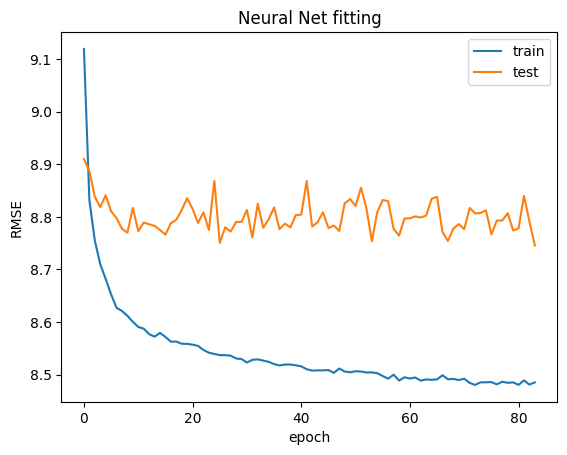

In [21]:
n_epochs = 84
train(model, optimizer, criterion, train_loader, test_loader, n_epochs)

In [22]:
def test(model, criterion, test_loader):
    test_loss = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = torch.tensor(
                scaler.inverse_transform(y_batch.reshape(-1, 1)).squeeze()
            ).to(device)
            y_pred = torch.tensor(
                scaler.inverse_transform(model(X_batch).reshape(-1, 1).cpu()).squeeze()
            ).to(device)
            test_loss.append(criterion(y_pred, y_batch))
                
    res_test.append(torch.sqrt(torch.mean(torch.tensor(test_loss))))
    print('RMSE Test', torch.sqrt(torch.mean(torch.tensor(test_loss))))
    
    predicts = torch.ones(len(test_loader.dataset))
    return predicts

In [23]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

RMSE Test tensor(8.7466, dtype=torch.float64)


## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Сначала запустил SGD с шагом 0.01, модель жутко переобучилась. Лучшее качество RMSE Test 8.7798 

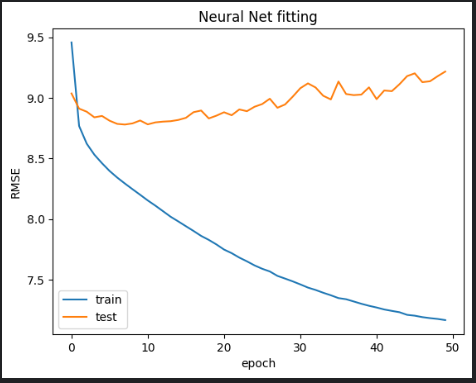

Потом решил запустить AdamW с шагом 0.0001 и декеем 0.01. В плане переобучения стало получше, но все равно плохо. Лучшее качество RMSE Test 8.7840

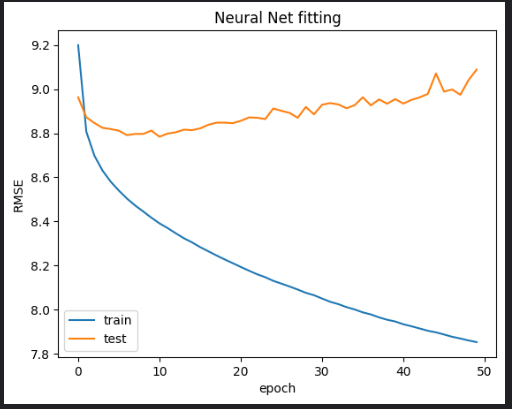

Поставил декей 0.1, переобучение уменьшилось. Лучший результат RMSE Test 8.7569

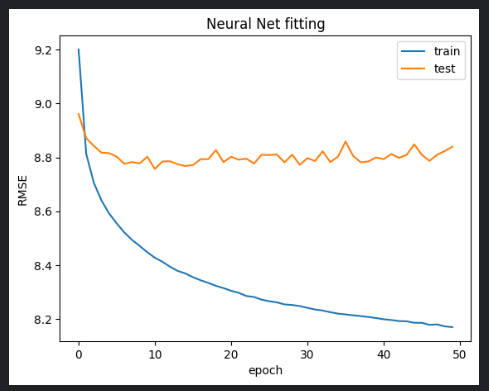

Добавил батчнорм, переобучение ещё уменьшилось. Лучший результат RMSE Test 8.7567

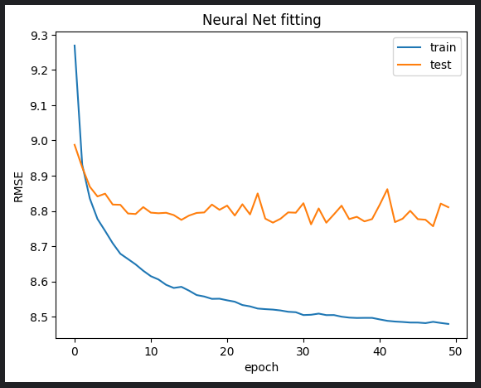

После этого запустил на 100 эпохах, но результат лучше не стал. Сделал шаг 0.0002 и на 84 эпохе выбил нужное качество.


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [24]:
from sklearn.preprocessing import LabelEncoder

X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [25]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [26]:
class Net89(nn.Module):
    def __init__(self):
        super(Net89, self).__init__()
        self.bn1 = nn.BatchNorm1d(90)
        self.fc1 = nn.Linear(90, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 89)
        
    def forward(self, X):
        X = F.relu(self.fc1(self.bn1(X)))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [27]:
set_random_seed(42)

train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True
)

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=True
)

model = Net89() 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

In [28]:
def train_classifier(model, optimizer, criterion, train_loader, test_loader, n_epochs):
    res_train = []
    res_test = []
    for epoch in tqdm(range(1, n_epochs + 1)):
        print(f'Epoch {epoch}/{n_epochs}')
        train_loss = []
        test_loss = []
        
        model.train()
        for X_batch, y_batch in tqdm(train_loader):
            optimizer.zero_grad()
            X_batch = X_batch
            y_batch = y_batch.type(torch.LongTensor)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                y_pred = model(X_batch)
                train_loss.append(criterion(y_pred, y_batch))
                
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch
                y_batch = y_batch.type(torch.LongTensor)
                y_pred = model(X_batch)
                test_loss.append(criterion(y_pred, y_batch))
                
        res_train.append(torch.mean(torch.tensor(train_loss)))
        res_test.append(torch.mean(torch.tensor(test_loss)))
        print('CrossEntropy Train', torch.mean(torch.tensor(train_loss)))
        print('CrossEntropy Test', torch.mean(torch.tensor(test_loss)))
        print()
    
    fig, ax = plt.subplots()
    ax.plot(res_train, label='train')
    ax.plot(res_test, label='test')
    ax.legend()
    ax.legend()
    ax.set_title('Neural Net fitting')
    ax.set_xlabel('epoch')
    ax.set_ylabel('CrossEntropy')
    plt.show()
                
            

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.1999)
CrossEntropy Test tensor(3.1388)

Epoch 2/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.1133)
CrossEntropy Test tensor(3.1155)

Epoch 3/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.0937)
CrossEntropy Test tensor(3.1007)

Epoch 4/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.0826)
CrossEntropy Test tensor(3.0975)

Epoch 5/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.0752)
CrossEntropy Test tensor(3.0912)

Epoch 6/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.0686)
CrossEntropy Test tensor(3.0882)

Epoch 7/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.0645)
CrossEntropy Test tensor(3.0845)

Epoch 8/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.0607)
CrossEntropy Test tensor(3.0817)

Epoch 9/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.0574)
CrossEntropy Test tensor(3.0836)

Epoch 10/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(3.0553)
CrossEntropy Test tensor(3.0818)



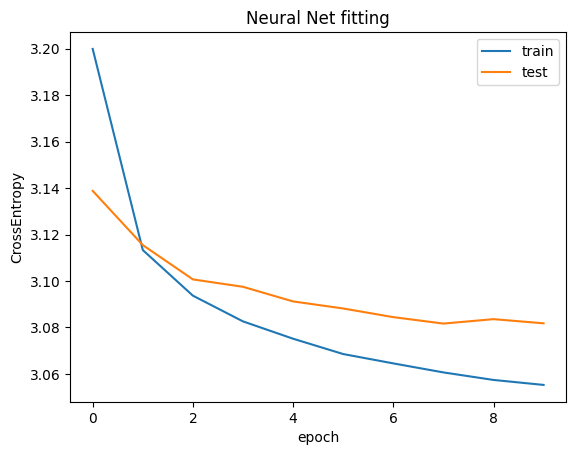

In [29]:
n_epochs = 10
train_classifier(model, optimizer, criterion, train_loader, test_loader, n_epochs)

In [30]:
def test_classification(model, criterion, test_loader, n_classes):
    n = len(test_loader.dataset)
    tp = np.zeros(n_classes)
    fp = np.zeros(n_classes)
    fn = np.zeros(n_classes)
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        for pred, true in zip(torch.max(y_pred, 1)[1], y_batch.int()):
            if pred == true:
                tp[true] += 1
            else:
                fp[pred] += 1
                fn[true] += 1
    
    precision = np.nanmean(tp / (tp + fp))
    recall = np.nanmean(tp / (tp + fn))
    accuracy = tp.sum() / n
    print(f'Accuracy {accuracy}')
    print(f'Precision {precision}')
    print(f'Recall {recall}')
    predicts = torch.ones(len(test_loader.dataset))
    return predicts

In [31]:
n_classes = 89
assert test_classification(model, criterion, test_loader, n_classes).shape[0] == y_test.shape[0]

Accuracy 0.0926205694363742
Precision 0.06906598872163552
Recall 0.03617496679382045


In [32]:
from sklearn.preprocessing import LabelEncoder

X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#10 бинов по десятилетиям
y_train = y_train // 10 * 10
y_test = y_test // 10 * 10
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [33]:
class Net10(nn.Module):
    def __init__(self):
        super(Net10, self).__init__()
        self.bn1 = nn.BatchNorm1d(90)
        self.fc1 = nn.Linear(90, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, X):
        X = F.relu(self.fc1(self.bn1(X)))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [34]:
set_random_seed(42)

train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True
)

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=True
)

model = Net10() 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(1.0093)
CrossEntropy Test tensor(0.9643)

Epoch 2/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(0.9499)
CrossEntropy Test tensor(0.9474)

Epoch 3/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(0.9389)
CrossEntropy Test tensor(0.9418)

Epoch 4/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(0.9333)
CrossEntropy Test tensor(0.9387)

Epoch 5/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(0.9290)
CrossEntropy Test tensor(0.9402)

Epoch 6/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(0.9264)
CrossEntropy Test tensor(0.9429)

Epoch 7/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(0.9237)
CrossEntropy Test tensor(0.9356)

Epoch 8/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(0.9217)
CrossEntropy Test tensor(0.9402)

Epoch 9/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(0.9205)
CrossEntropy Test tensor(0.9355)

Epoch 10/10


  0%|          | 0/7246 [00:00<?, ?it/s]

CrossEntropy Train tensor(0.9193)
CrossEntropy Test tensor(0.9293)



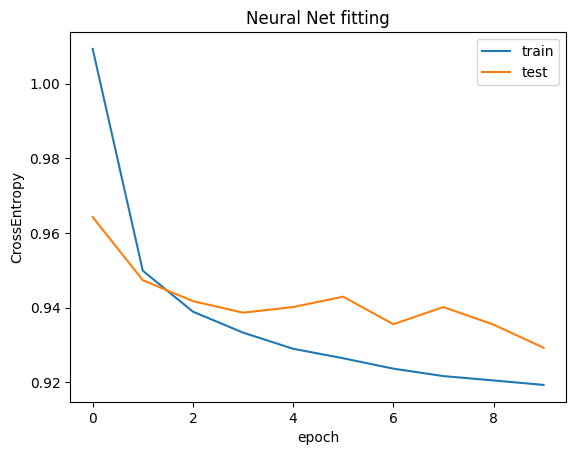

In [35]:
n_epochs = 10
train_classifier(model, optimizer, criterion, train_loader, test_loader, n_epochs)

In [36]:
n_classes = 10
assert test_classification(model, criterion, test_loader, n_classes).shape[0] == y_test.shape[0]

Accuracy 0.6497772612822003
Precision 0.5174849985071169
Recall 0.1882290757553724


Очевидно, что модель, где с 10 классами показала себя намного лучше с точки зрения accuracy, precision, recall. Как мне кажется, на это есть 2 причины. Во-первых, мне кажется, что чем меньше классов, тем проще получить хорошее качество. Во-вторых, в случае с 89 классами очень много классов практически не отличаются друг от друга. Условно говоря, песни, которые выходили в 1972 и в 1973 похожи, а если смотреть уже на десятилетие выхода песни, то шанс получить нормальную модель выше, потому что классы сильнее друг от друга отличаются.

Помимо основной задачи главное отличие моделей классификации и регрессии, как мне кажется, в том, что обучение в задачах регрессии может происходить на той же функции потерь, что и для замерки качетсва(RMSE, MSE). В задачах же классификации невозможно обучить модель, используя F_score, recall или precision в качесте функции потерь, поэтому достичь хорошего качества в моделях классификации сложнее.